In [1]:
#download wfdb and spectrum
%%capture
!pip install wfdb
!pip install spectrum
! pip  install scipy

In [2]:
#download dataset of chf database
%%capture
!wget -r -N -c -np https://physionet.org/files/chfdb/1.0.0/

In [3]:
#importing all liberaris
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from spectrum import *
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [4]:
with open('/content/physionet.org/files/chfdb/1.0.0/RECORDS') as f:
    lines = f.readlines()

In [5]:
lines_list = []
for i in lines:
  lines_list.append(i[0:5])

In [6]:
lines_list

['chf01',
 'chf02',
 'chf03',
 'chf04',
 'chf05',
 'chf06',
 'chf07',
 'chf08',
 'chf09',
 'chf10',
 'chf11',
 'chf12',
 'chf13',
 'chf14',
 'chf15']

In [9]:
#download all content in chf dataset and select all features for return them to csv file
folderPath = "/content/physionet.org/files/chfdb/1.0.0"
file_names = ["chf01", "chf02", "chf03", "chf04", "chf05", "chf06", "chf07", "chf08",
              "chf09", "chf10", "chf11", "chf12", "chf13", "chf14", "chf15"]
n_features = 32
#select label for return them to csv file
csv_header = ["f"+str(i) for i in range(n_features+1)] + ["label"]
csv_header = ",".join(csv_header)
data = []
#append all csv files in one file collect all features with lables
#range signals by read samples
for i in range(15):
    label = 1
    print("Process sample " + file_names[i])
    record = wfdb.rdsamp(os.path.join(folderPath, file_names[i]))
    signal1 = record[0][:, 0]
    for j in range(0, 100 * 1000, 1000):
        AR, rho, ref = arburg(signal1[j:j+1000], n_features)
        features = [k.real for k in AR]
        features.append(rho)
        features.append(label)
        data.append(features)
#save chf database in one csv file
np.savetxt("chf2_final.csv", data, delimiter=",", header=csv_header, comments="")

Process sample chf01
Process sample chf02
Process sample chf03
Process sample chf04
Process sample chf05
Process sample chf06
Process sample chf07
Process sample chf08
Process sample chf09
Process sample chf10
Process sample chf11
Process sample chf12
Process sample chf13
Process sample chf14
Process sample chf15


In [10]:
#install matplotlib virgin 3.1.3 to display signals
%%capture
!pip install matplotlib==3.1.3

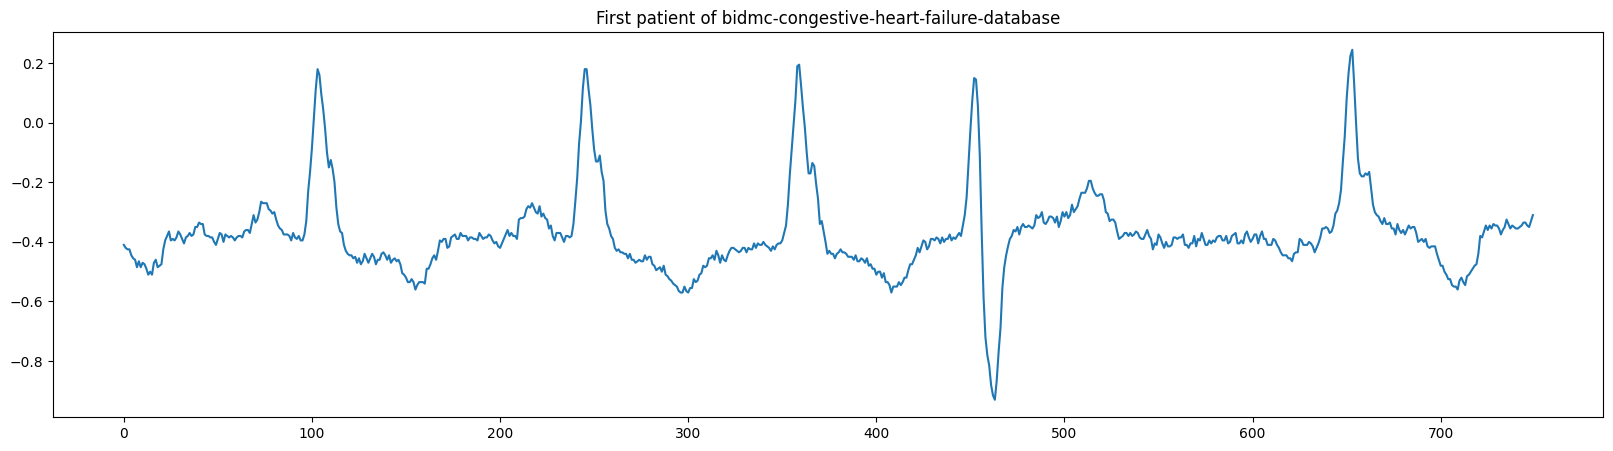

In [11]:
#read signals with samples of one patient
record = wfdb.rdsamp("/content/physionet.org/files/chfdb/1.0.0/chf06")
signal = record[0][:, 0]
plt.figure(figsize=(20,5))
plt.plot(signal[50:800])
plt.title("First patient of bidmc-congestive-heart-failure-database")
plt.show()

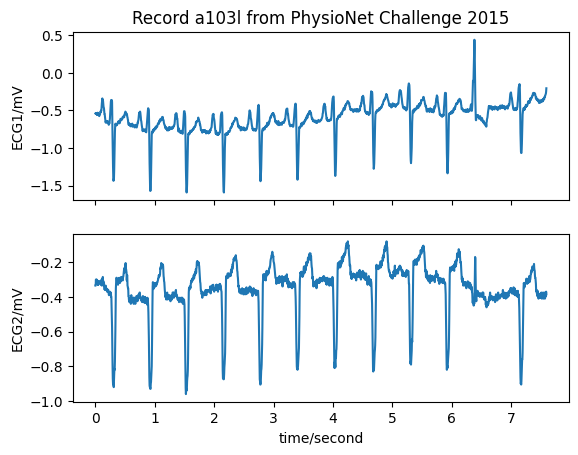

{'record_name': 'chf02',
 'n_sig': 2,
 'fs': 250,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 1900,
 'base_time': datetime.time(13, 22, 0, 400000),
 'base_date': None,
 'comments': ['Age: 61  Sex: F  NYHA class: III-IV'],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.54 , -0.335],
        [-0.545, -0.335],
        [-0.535, -0.3  ],
        ...,
        [-0.275, -0.395],
        [-0.25 , -0.37 ],
        [-0.205, -0.385]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['chf02.dat', 'chf02.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-108, -67],
 'checksum': [37820, 63905],
 'block_size': [0, 0]}

In [12]:
record = wfdb.rdrecord('/content/physionet.org/files/chfdb/1.0.0/chf02',sampfrom=100 ,sampto=2000)
wfdb.plot_wfdb(record=record, title='Record a103l from PhysioNet Challenge 2015')
display(record.__dict__)

In [13]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [14]:
invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t",
    "u", "`", "'", "^", "|", "~", "+", "s",
    "T", "*", "D", "=", '"', "@"]

abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V",
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"]

In [15]:
#for classification of AF classes
def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0

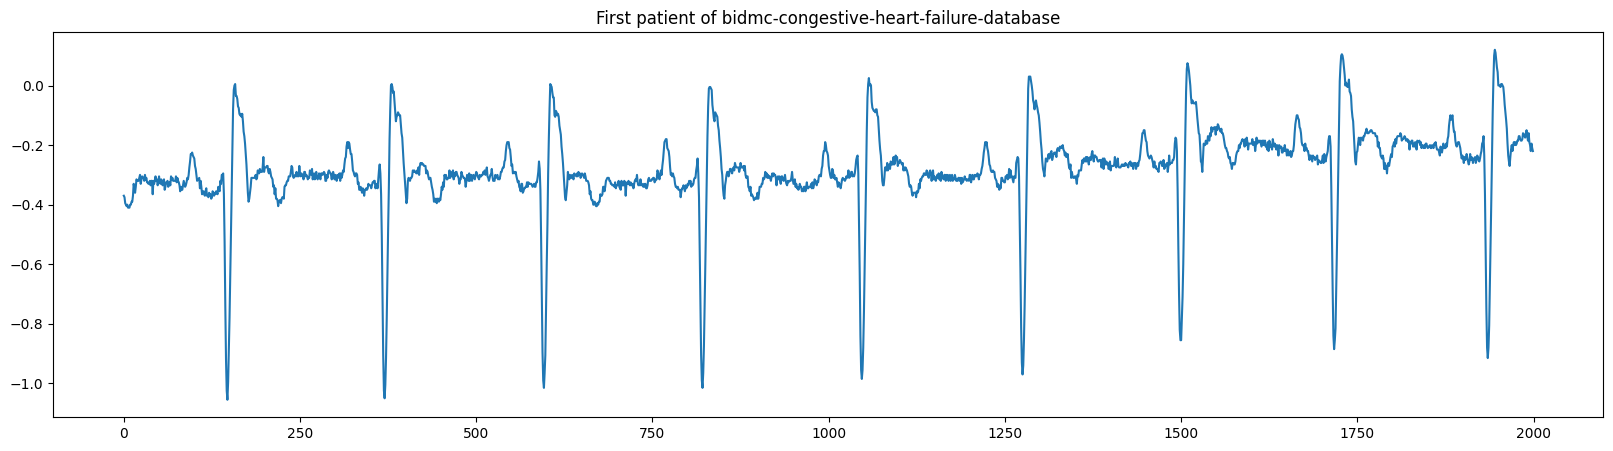

In [16]:
#read signals with samples of one patient
record = wfdb.rdsamp("/content/physionet.org/files/chfdb/1.0.0/chf08")
signal = record[0][:, 0]
plt.figure(figsize=(20,5))
plt.plot(signal[:2000])
plt.title("First patient of bidmc-congestive-heart-failure-database")
plt.show()

In [17]:
#The beginnings of the disease dataset called -- [ Physikalisch-Technische Bundesanstalt (PTB) ]
%%capture
!wget -r -N -c -np https://physionet.org/files/ptbdb/1.0.0/

In [18]:
#download all content in PTB dataset and select all features for return them to csv file
folderPath ="/content/physionet.org/files/ptbdb/1.0.0/patient087"
file_names = ["s0321lre", "s0326lre", "s0330lre"]
n_features = 32

csv_header = ["f"+str(i) for i in range(n_features+1)] + ["label"]
csv_header = ",".join(csv_header)
data = []
#select range and lable for comparing with normal and CHF signals
for i in range(3):
    label = 1
    print("Process sample " + file_names[i])
    record = wfdb.rdsamp(os.path.join(folderPath, file_names[i]))
    signal1 = record[0][:, 0]
    for j in range(0, len(signal1), 1000):
        AR, rho, ref = arburg(signal1[j:j+1000], n_features)
        features = [k.real for k in AR]
        features.append(rho)
        features.append(label)
        data.append(features)
#save all file to one csv file
np.savetxt("chf_final.csv", data, delimiter=",", header=csv_header, comments="")

Process sample s0321lre
Process sample s0326lre
Process sample s0330lre


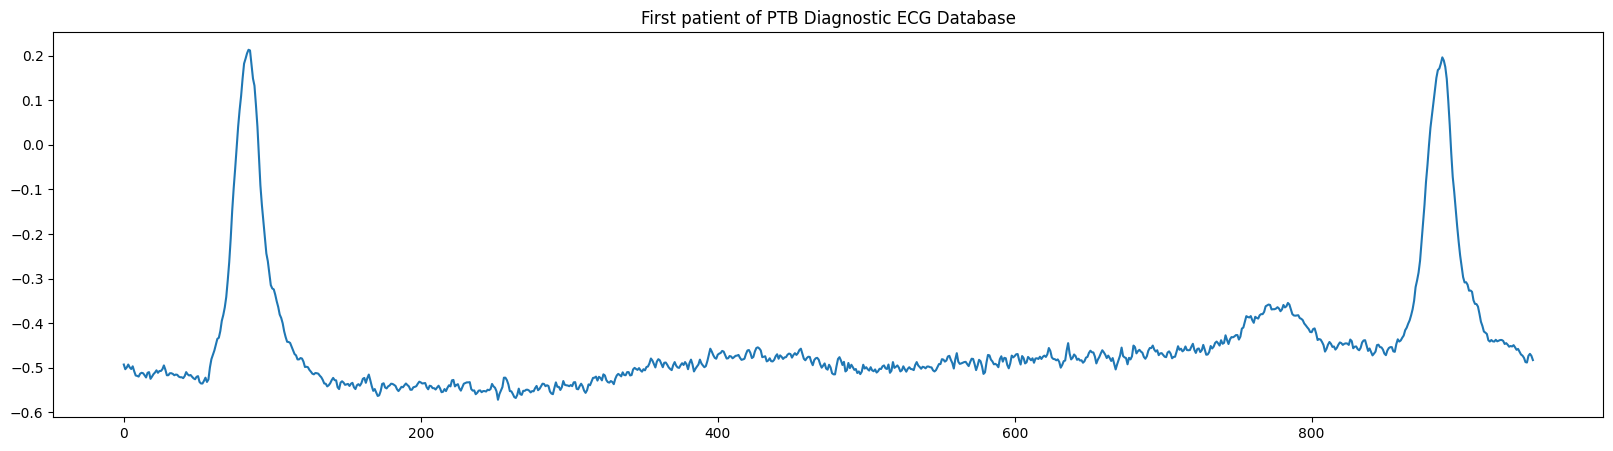

In [19]:
#read signals with samples of one patient
record = wfdb.rdsamp("/content/physionet.org/files/ptbdb/1.0.0/patient087/s0321lre")
signal = record[0][:, 0]
plt.figure(figsize=(20,5))
plt.plot(signal[50:1000])
plt.title("First patient of PTB Diagnostic ECG Database")
plt.show()

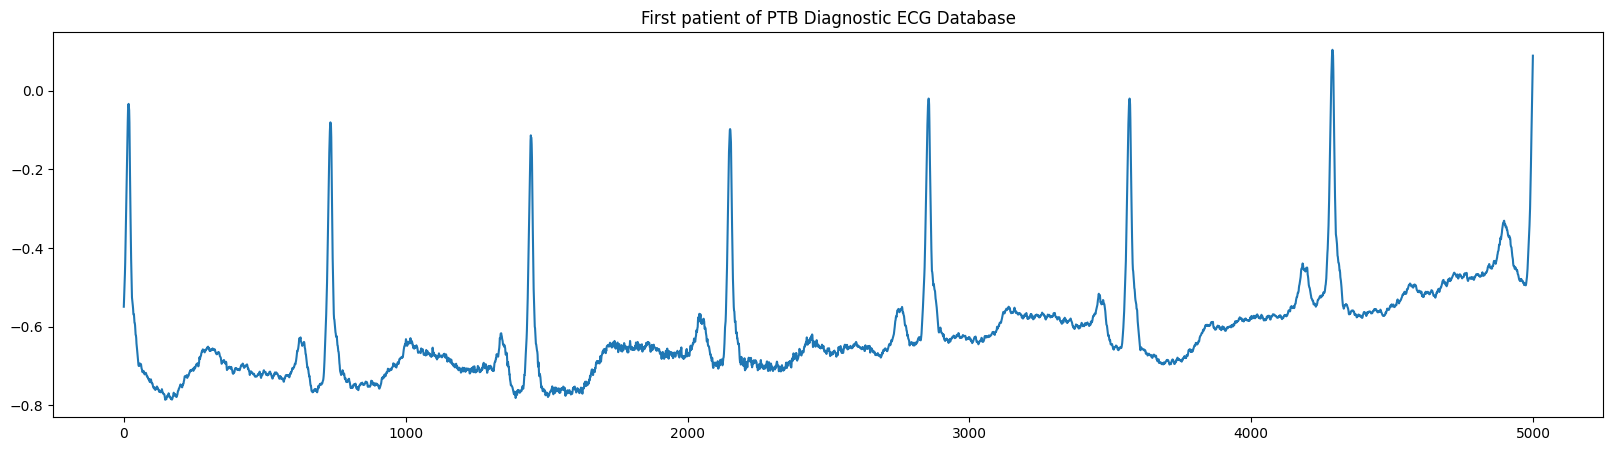

In [20]:
#read signals with samples of one patient
record = wfdb.rdsamp("/content/physionet.org/files/ptbdb/1.0.0/patient087/s0326lre")
signal = record[0][:, 0]
plt.figure(figsize=(20,5))
plt.plot(signal[:5000])
plt.title("First patient of PTB Diagnostic ECG Database")
plt.show()

In [21]:
#download MIT dataset for Diveing into the disease called -- [ MIT-BIH Normal ]
%%capture
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

In [22]:
#download all content in PTB dataset and select all features for return them to csv file
#select range and lable for comparing with normal and CHF signals
folderPath = "/content/physionet.org/files/mitdb/1.0.0"
n_features = 32

csv_header = ["f"+str(i) for i in range(n_features + 1)] + ["label"]
csv_header = ",".join(csv_header)
data = []

for i in range(9):
    label = 0
    print("Process sample " + str(100 + i))

    # Using WFDB for reading dat final and get signal datas
    record = wfdb.rdsamp(os.path.join(folderPath, str(100 + i)))
    signal1 = record[0][:, 0]
    signal2 = record[0][:, 1]
    for j in range(0, 100 * 1000, 1000):

        AR, rho, ref = arburg(signal1[j:j+1000], n_features)
        features = [k.real for k in AR]
        features.append(rho)
        features.append(label)
        data.append(features)
#save all normal signals to one file csv
np.savetxt("normal_final.csv", data, delimiter=",", header=csv_header, comments="")

Process sample 100
Process sample 101
Process sample 102
Process sample 103
Process sample 104
Process sample 105
Process sample 106
Process sample 107
Process sample 108


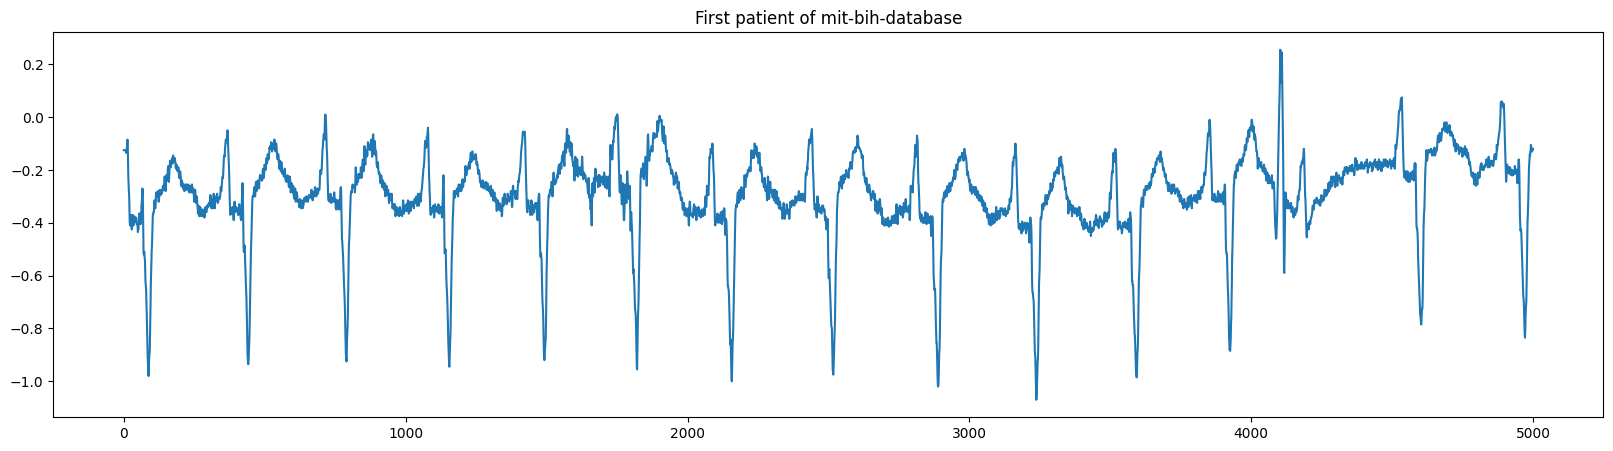

In [23]:
#read signals with samples of one patient
record = wfdb.rdsamp("/content/physionet.org/files/mitdb/1.0.0/108")
signal = record[0][:, 0]
plt.figure(figsize=(20,5))
plt.plot(signal[:5000])
plt.title("First patient of mit-bih-database")
plt.show()

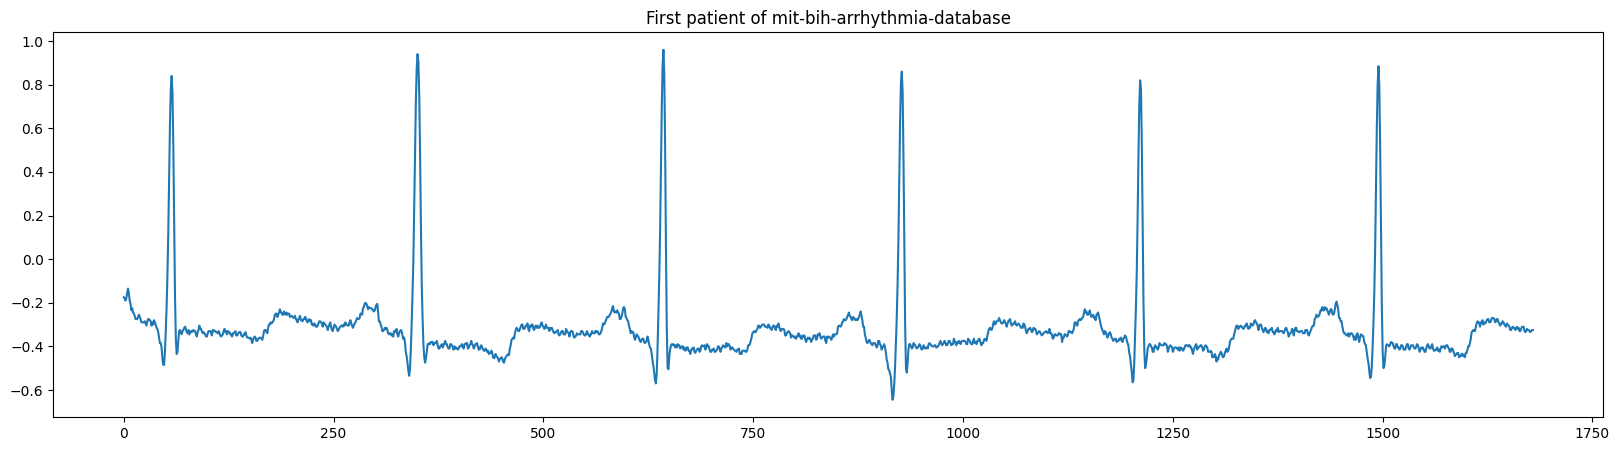

In [24]:
#read signals with samples of one patient
record = wfdb.rdsamp("/content/physionet.org/files/mitdb/1.0.0/100")
signal = record[0][:, 0]
plt.figure(figsize=(20,5))
plt.plot(signal[20:1700])
plt.title("First patient of mit-bih-arrhythmia-database")
plt.show()

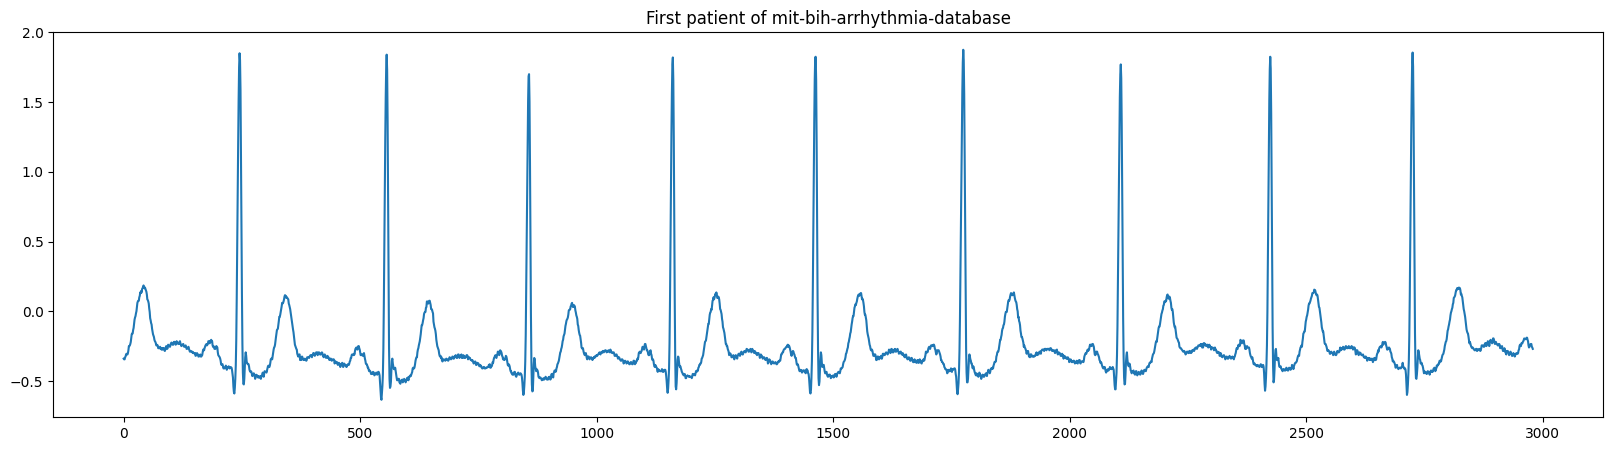

In [25]:
#read signals with samples of one patient
record = wfdb.rdsamp("/content/physionet.org/files/mitdb/1.0.0/103")
signal = record[0][:, 0]
plt.figure(figsize=(20,5))
plt.plot(signal[20:3000])
plt.title("First patient of mit-bih-arrhythmia-database")
plt.show()

In [26]:
#read all csv files for 3 datasets and add concatinate in one file
chf = pd.read_csv('/content/chf_final.csv')
chf2 = pd.read_csv('/content/chf2_final.csv')
normal = pd.read_csv('/content/normal_final.csv')

case1_data = pd.concat([chf2, normal]).sample(frac=1, random_state=42).reset_index(drop=True)
case2_data = pd.concat([chf, normal]).sample(frac=1, random_state=42).reset_index(drop=True)

In [27]:
case1_data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f24,f25,f26,f27,f28,f29,f30,f31,f32,label
0,-1.927155,0.864364,0.221220,-0.160063,-0.165576,0.201468,0.213512,-0.212117,-0.084498,0.069968,...,0.274082,-0.144905,0.064275,-0.105614,0.064229,-0.039093,0.102833,-0.066850,0.000302,0.0
1,-2.063554,1.337990,-0.123915,-0.373354,0.239781,0.072032,-0.048597,0.041915,-0.135524,0.140135,...,0.015048,-0.079901,0.151554,-0.024469,-0.195504,0.074549,0.142882,-0.092725,0.000440,0.0
2,-2.156347,1.643981,-0.573553,0.086985,0.027208,0.115729,-0.130396,0.119553,-0.163605,0.026528,...,0.109236,-0.169066,0.195373,-0.159368,0.086347,-0.061452,0.066768,-0.034059,0.004973,1.0
3,-2.120353,1.709472,-0.401904,-0.467594,0.345391,0.059790,-0.191985,0.061708,0.050731,-0.085185,...,-0.082376,0.137784,-0.156994,0.145437,-0.064888,-0.021217,0.093475,-0.081071,0.000526,0.0
4,-1.812824,0.645323,0.259712,-0.041975,-0.194459,0.108682,0.236343,-0.020856,-0.225552,0.036210,...,0.100334,-0.024952,0.016764,-0.028794,-0.094249,0.009640,0.186449,-0.111543,0.000239,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,-2.177265,1.586058,-0.107540,-0.499291,0.166815,0.137656,-0.081187,0.014472,-0.067596,0.059110,...,0.125857,-0.055806,-0.027654,0.127735,-0.176334,0.068897,0.054359,-0.048839,0.000508,0.0
2396,-2.158511,1.276956,-0.002963,-0.125402,-0.006529,0.101551,0.105469,-0.196656,-0.148007,0.158189,...,-0.031920,0.182373,-0.206892,0.083819,0.045885,0.012272,-0.085065,0.038059,0.002233,1.0
2397,-1.355212,0.161882,0.185388,0.026835,-0.018604,-0.050578,-0.035967,0.187270,0.008494,-0.133789,...,0.089200,-0.046205,-0.020087,-0.106065,0.101591,0.034810,-0.065902,0.002266,0.000395,1.0
2398,-1.540226,0.281119,0.395491,0.084065,-0.181004,-0.052878,0.039959,0.092852,-0.055828,-0.042271,...,0.052468,-0.096297,-0.036612,0.088093,-0.023710,-0.028251,0.082745,-0.057346,0.000504,1.0


In [28]:
case2_data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f24,f25,f26,f27,f28,f29,f30,f31,f32,label
0,-2.265023,1.461482,0.107561,-0.261557,-0.097318,0.059194,0.114479,-0.134727,-0.063845,0.100043,...,0.053494,-0.072619,0.078963,-0.105126,-0.004619,-0.006460,0.126069,-0.080870,0.000504,0.0
1,-1.899960,0.841488,0.150277,-0.079425,-0.112803,0.008420,0.391481,-0.190227,-0.188070,0.099806,...,0.093518,-0.001991,-0.106393,0.130260,-0.185995,0.056300,0.181203,-0.123251,0.000300,0.0
2,-1.853443,0.679039,0.308277,-0.112221,-0.200224,0.246629,0.175521,-0.119156,-0.229158,0.058893,...,0.156517,-0.042584,-0.017426,-0.004760,0.013445,-0.053737,0.115707,-0.068162,0.000252,0.0
3,-1.862857,1.353333,-1.426088,1.642144,-1.573750,1.764075,-1.715826,1.762633,-1.841344,1.870201,...,-0.492960,0.477715,-0.406829,0.253699,-0.175827,0.089711,-0.128647,0.097412,0.000032,1.0
4,-1.960904,1.430913,-1.394751,1.691030,-1.576092,1.810361,-1.873483,1.808411,-1.829348,1.793347,...,-0.326232,0.311697,-0.347482,0.195648,-0.131405,0.152779,-0.132001,0.052163,0.000022,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,-2.151244,1.512572,-0.275184,-0.153927,-0.026236,0.235392,-0.156844,0.155897,-0.129513,0.011104,...,0.112104,-0.128118,0.058356,-0.023068,-0.018595,-0.028737,0.085377,-0.041694,0.000608,0.0
1244,-2.312369,1.765627,-0.175437,-0.517315,0.192432,0.079663,0.009120,-0.026579,-0.054549,0.012585,...,-0.037593,0.045301,0.014064,-0.161253,0.248786,-0.207124,0.102212,-0.024344,0.001171,0.0
1245,-2.539417,2.297783,-0.476333,-0.700667,0.324292,0.350130,-0.183106,-0.318190,0.355396,-0.052485,...,-0.053348,0.181523,-0.182166,0.047012,0.083955,-0.130017,0.077339,-0.014456,0.000832,0.0
1246,-1.953577,0.928300,0.217405,-0.250585,-0.113025,0.227803,0.071172,-0.015514,-0.126138,0.037875,...,0.054274,0.111991,-0.094859,-0.120269,0.121718,-0.068039,0.092973,-0.046333,0.000303,0.0


In [29]:
case1_data.isna().sum()

f0       0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
f9       0
f10      0
f11      0
f12      0
f13      0
f14      0
f15      0
f16      0
f17      0
f18      0
f19      0
f20      0
f21      0
f22      0
f23      0
f24      0
f25      0
f26      0
f27      0
f28      0
f29      0
f30      0
f31      0
f32      0
label    0
dtype: int64

In [30]:
input = case1_data.drop(['label'],axis=1)
output = case1_data['label']

In [31]:
input

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32
0,-1.927155,0.864364,0.221220,-0.160063,-0.165576,0.201468,0.213512,-0.212117,-0.084498,0.069968,...,-0.174754,0.274082,-0.144905,0.064275,-0.105614,0.064229,-0.039093,0.102833,-0.066850,0.000302
1,-2.063554,1.337990,-0.123915,-0.373354,0.239781,0.072032,-0.048597,0.041915,-0.135524,0.140135,...,0.062038,0.015048,-0.079901,0.151554,-0.024469,-0.195504,0.074549,0.142882,-0.092725,0.000440
2,-2.156347,1.643981,-0.573553,0.086985,0.027208,0.115729,-0.130396,0.119553,-0.163605,0.026528,...,-0.113383,0.109236,-0.169066,0.195373,-0.159368,0.086347,-0.061452,0.066768,-0.034059,0.004973
3,-2.120353,1.709472,-0.401904,-0.467594,0.345391,0.059790,-0.191985,0.061708,0.050731,-0.085185,...,0.004331,-0.082376,0.137784,-0.156994,0.145437,-0.064888,-0.021217,0.093475,-0.081071,0.000526
4,-1.812824,0.645323,0.259712,-0.041975,-0.194459,0.108682,0.236343,-0.020856,-0.225552,0.036210,...,-0.060579,0.100334,-0.024952,0.016764,-0.028794,-0.094249,0.009640,0.186449,-0.111543,0.000239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,-2.177265,1.586058,-0.107540,-0.499291,0.166815,0.137656,-0.081187,0.014472,-0.067596,0.059110,...,-0.146079,0.125857,-0.055806,-0.027654,0.127735,-0.176334,0.068897,0.054359,-0.048839,0.000508
2396,-2.158511,1.276956,-0.002963,-0.125402,-0.006529,0.101551,0.105469,-0.196656,-0.148007,0.158189,...,-0.073518,-0.031920,0.182373,-0.206892,0.083819,0.045885,0.012272,-0.085065,0.038059,0.002233
2397,-1.355212,0.161882,0.185388,0.026835,-0.018604,-0.050578,-0.035967,0.187270,0.008494,-0.133789,...,0.024320,0.089200,-0.046205,-0.020087,-0.106065,0.101591,0.034810,-0.065902,0.002266,0.000395
2398,-1.540226,0.281119,0.395491,0.084065,-0.181004,-0.052878,0.039959,0.092852,-0.055828,-0.042271,...,-0.004164,0.052468,-0.096297,-0.036612,0.088093,-0.023710,-0.028251,0.082745,-0.057346,0.000504


In [32]:
output

0       0.0
1       0.0
2       1.0
3       0.0
4       0.0
       ... 
2395    0.0
2396    1.0
2397    1.0
2398    1.0
2399    1.0
Name: label, Length: 2400, dtype: float64

In [33]:
#splitting data for fit
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
# splitting 33% for testing
x_train , x, y_train , y = train_test_split(input , output , test_size = 0.35 , random_state = 42)
# splitting the other part to trainset and validation set
x_test , x_val , y_test , y_val = train_test_split(x , y , test_size = 0.5 , random_state = 42)

In [34]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(1560, 33)
(420, 33)
(420, 33)


In [35]:
from keras.utils.np_utils import to_categorical
Y_train=to_categorical(y_train,5)
Y_test=to_categorical(y_test,5)

In [36]:
x_train = x_train.values.reshape(len(x_train), x_train.shape[1],1)
x_test = x_test.values.reshape(len(x_test), x_test.shape[1],1)

In [37]:
print(x_train.shape)
print(x_test.shape)

(1560, 33, 1)
(420, 33, 1)


In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,BatchNormalization,Flatten,MaxPool1D,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

model=Sequential()
model.add(Conv1D(32,(3),strides=(1),padding='same',activation='linear', input_shape=(x_train.shape[1],1)))
model.add(MaxPool1D(2))
model.add(Dropout(0.25))
model.add(Conv1D(64,(3),strides=(1),padding='same',activation='relu'))
model.add(MaxPool1D(2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32,activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 33, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 64)            0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 64)             0

In [39]:
import tensorflow as tf
callbacks = [EarlyStopping(monitor='val_loss',min_delta=0.01, patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

#for begin data training and validation with epochs
hist_cnn = model.fit(
    x_train,
    y_train,
    batch_size=2,
    epochs=100,
    validation_data=(x_val, y_val),callbacks=[callbacks]
)

Epoch 1/100
780/780 [==============================] - 14s 5ms/step - loss: 0.5526 - accuracy: 0.7391 - val_loss: 0.3238 - val_accuracy: 0.8905
Epoch 2/100
780/780 [==============================] - 4s 5ms/step - loss: 0.3074 - accuracy: 0.8795 - val_loss: 0.1742 - val_accuracy: 0.9476
Epoch 3/100
780/780 [==============================] - 3s 4ms/step - loss: 0.1955 - accuracy: 0.9295 - val_loss: 0.1127 - val_accuracy: 0.9643
Epoch 4/100
780/780 [==============================] - 3s 4ms/step - loss: 0.1507 - accuracy: 0.9462 - val_loss: 0.0874 - val_accuracy: 0.9738
Epoch 5/100
780/780 [==============================] - 4s 5ms/step - loss: 0.1152 - accuracy: 0.9603 - val_loss: 0.0728 - val_accuracy: 0.9786
Epoch 6/100
780/780 [==============================] - 4s 5ms/step - loss: 0.1070 - accuracy: 0.9609 - val_loss: 0.0686 - val_accuracy: 0.9762
Epoch 7/100
780/780 [==============================] - 3s 4ms/step - loss: 0.0939 - accuracy: 0.9718 - val_loss: 0.0611 - val_accuracy: 0.981

In [40]:
model.evaluate(x_val, y_val,batch_size=1)

420/420 [==============================] - 1s 3ms/step - loss: 0.0559 - accuracy: 0.9833


[0.055876076221466064, 0.9833333492279053]

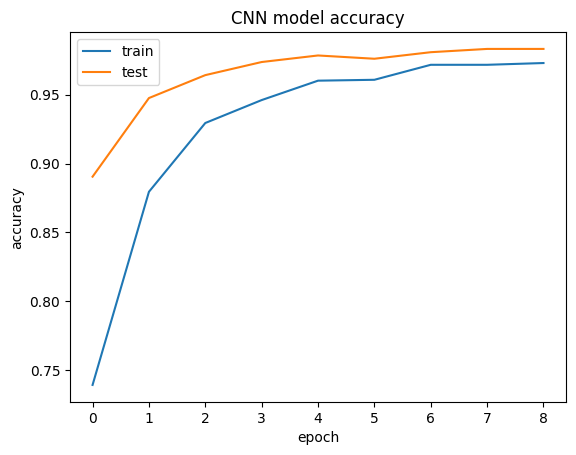

In [41]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

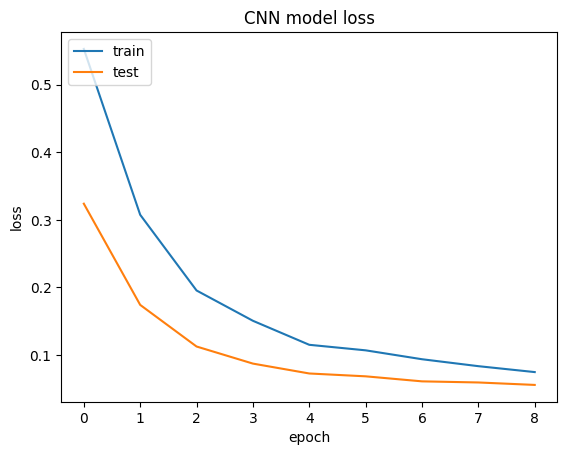

In [42]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
import tensorflow as tf
model=tf.keras.models.load_model("/content/drive/MyDrive/ecg input/best_model.h5")

In [55]:
import os
import numpy as np
import pandas as pd

folderPath = "/content/drive/MyDrive/tessst/"
file_names = ["numbers.csv"]
n_features = 32
csv_header = ["f"+str(i) for i in range(n_features+1)]
csv_header = ",".join(csv_header)
data = []

for file in file_names:
    label = 1
    print("Processing file " + file)
    ecg_signal = np.loadtxt(os.path.join(folderPath, file), delimiter=",")
    for j in range(0, 10 , 10):
       AR, rho, ref = arburg(ecg_signal, n_features)
       features = [k.real for k in AR]
       features.append(rho)
       data.append(features)
np.savetxt("test.csv", data, delimiter=",", header=csv_header, comments="")

Processing file numbers.csv


In [56]:
import pandas as pd
ecg=pd.read_csv('/content/drive/MyDrive/tessst/test (6).csv')
print(ecg)

                 f0        f1        f2      f3        f4       f5       f6  \
-1.561928  1.166564 -0.734382  0.145997  0.3034 -0.264337  0.05345 -0.03453   

                 f7        f8        f9  ...       f23       f24       f25  \
-1.561928 -0.103088  0.097558  0.039661  ... -0.012979 -0.009154 -0.008366   

                f26       f27       f28       f29     f30          f31  f32  
-1.561928  0.019675 -0.001671 -0.010647  0.004905 -0.0253  2098.674343  1.0  

[1 rows x 33 columns]


In [57]:
#y = ecg.reshape(len(ecg), ecg.shape[1],0)
print(ecg.shape)

(1, 33)


In [58]:
predictions = model.predict(ecg)

1/1 [==============================] - 0s 28ms/step


In [59]:
print(predictions[0])

[0.]
